In [37]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA
from qiskit_algorithms.optimizers import COBYLA, SPSA, POWELL
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.noise import NoiseModel, depolarizing_error

import datetime

Definition of the necessary functions

In [38]:
def get_portfolio_data(tickers, start_date, end_date, num_assets):
    """
    Fetches historical data and calculates expected return (mu) and covariance (sigma).
    """
    
    if tickers == []:
        #Fetch random data from qiskit finance
        seed = 1234
        tickers = [("TICKER%s" % i) for i in range(num_assets)]
        data = RandomDataProvider(
        tickers=tickers,
        start=datetime.datetime(2016, 1, 1),
        end=datetime.datetime(2016, 1, 30),
        seed=seed,
        )
        data.run()
        mu = data.get_period_return_mean_vector()
        sigma = data.get_period_return_covariance_matrix()
    else:
        #Fetch raw data from Yahoo Finance
        data = yf.download(tickers, start=start_date, end=end_date)['Close']
        
        #Calculate daily returns (percentage change)
        daily_returns = data.pct_change().dropna()
        
        #Calculate Mean Vector (mu) and Covariance Matrix (sigma)
        '''252 because if not, mu is the average daily returns and overall we want annual returns because it makes more sense.
        So just multiply the average daily returns by the 252 annual trading days'''
        mu = daily_returns.mean() * 252
        sigma = daily_returns.cov() * 252
    
    return mu, sigma, data

def normalize_data(mu, sigma):
    """
    Normalizes data to [0, 1] range.
    """
    mu_min = mu.min()
    mu_max = mu.max()
    mu_normalized = (mu - mu_min) / (mu_max - mu_min) #Normalization between [0,1]

    sigma_max = sigma.max().max()
    sigma_normalized = sigma / sigma_max #Normalization of sigma (the covariance matrix)
    
    return mu_normalized, sigma_normalized

def create_portfolio_qp(mu, sigma, q=0.5, budget=None):
    """
    Creates a Quadratic Program for the Portfolio Optimization problem.
    
    Args:
        mu (numpy.ndarray): Expected returns vector.
        sigma (numpy.ndarray): Covariance matrix.
        q (float): Risk factor (0 = high risk/high return, 1 = low risk).
        budget (int): Number of assets to select. If None, defaults to half the assets.
        
    Returns:
        qp (QuadraticProgram): The mathematical formulation of the problem.
        penalty (float): The recommended penalty scaling factor for QUBO conversion.
    """
    num_assets = len(mu)
    
    if budget is None:
        budget = num_assets // 2
        
    # Set parameter to scale the budget penalty term
    penalty = num_assets 
    
    # Create the portfolio instance
    portfolio = PortfolioOptimization(
        expected_returns=mu, 
        covariances=sigma, 
        risk_factor=q, 
        budget=budget
    )
    
    # Convert to Qiskit's QuadraticProgram format
    qp = portfolio.to_quadratic_program()
    
    return qp, penalty,portfolio

def print_result(result,portfolio):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

def get_aproximation_ratio(solution_result, mu, sigma, q, budget,greedy=False, energy = None):
    """
    Computes the approximation ratio: (C_max - C_obj) / (C_max - C_min)
    """
    
    # Check if inputs are Pandas types (have a .values attribute) and convert if so
    mu_arr = mu.values if hasattr(mu, 'values') else mu
    sigma_arr = sigma.values if hasattr(sigma, 'values') else sigma

    # 1. Compute the TRUE MINIMUM (Best possible value)
    portfolio_min = PortfolioOptimization(
        expected_returns=mu_arr,
        covariances=sigma_arr,    
        risk_factor=q, 
        budget=budget
    )
    qp_min = portfolio_min.to_quadratic_program()
    exact_mes = NumPyMinimumEigensolver()
    exact_optimizer = MinimumEigenOptimizer(exact_mes)
    result_min = exact_optimizer.solve(qp_min)
    c_min = result_min.fval

    # 2. Compute the TRUE MAXIMUM (Worst possible value)
    # Note: We negate the numpy arrays, which works perfectly
    portfolio_max = PortfolioOptimization(
        expected_returns=-mu_arr, 
        covariances=-sigma_arr, 
        risk_factor=q, 
        budget=budget
    )
    qp_max = portfolio_max.to_quadratic_program()
    result_max = exact_optimizer.solve(qp_max)
    c_max = -result_max.fval 

    # 3. Get the QAOA Value
    if greedy and energy is None:
        raise ValueError("For greedy=True, energy must be provided.")
    if greedy:
        c_obj = energy
    else:
        c_obj = solution_result.fval

    # 4. Calculate Ratio
    denominator = c_max - c_min
    if abs(denominator) < 1e-9:
        return 0.0
        
    ratio = (c_max - c_obj) / denominator
    return ratio

def run_qaoa_experiments(qp, penalty, reps, optimizers_to_test, mu, sigma, q, budget):
    """
    Runs QAOA using the provided optimizers, calculates approximation ratios, 
    and returns the results.
    """
    results_data = {}
    
    print(f"Running QAOA experiments with reps={reps}...")
    print(f"{'Optimizer':<10} | {'Ratio C(Z)':<8} | {'Value':<10} | {'Best String':<10}")
    print("-" * 55)
    
    for label, optimizer in optimizers_to_test.items():
        # Reset seed for fairness
        algorithm_globals.random_seed = 1234
        
        # Configure and Run
        qaoa_mes = QAOA(sampler=Sampler(), optimizer=optimizer, reps=reps)
        qaoa = MinimumEigenOptimizer(qaoa_mes, penalty=penalty)
        result = qaoa.solve(qp)
        
        #Calculate Approximation Ratio
        ratio = get_aproximation_ratio(result, mu, sigma, q, budget)
        
        # Capture optimal string
        found_optimal_str = "".join(str(int(x)) for x in result.x)
        
        # Extract Probabilities
        eigenstate = result.min_eigen_solver_result.eigenstate
        probabilities = (
            eigenstate.binary_probabilities()
            if hasattr(eigenstate, 'binary_probabilities')
            else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
        )
        
        sorted_probs = dict(sorted(probabilities.items(), key=lambda item: item[1], reverse=True))
        
        # Store Data
        results_data[label] = {
            "probs": sorted_probs,
            "optimal_str": found_optimal_str,
            "optimal_val": result.fval,
            "ratio": ratio
        }
        
        # Print nicely formatted row
        print(f"{label:<10} | {ratio:.4f}   | {result.fval:.4f}     | {found_optimal_str}")
        
    return results_data

def plot_qaoa_results(results_data):
    """
    Plots histograms from the data dictionary returned by run_qaoa_experiments.
    Highlights the optimal solution found in each run in GREEN.
    """
    num_plots = len(results_data)
    fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(12, 5 * num_plots))
    
    # Handle single plot case (axes is not a list if nrows=1)
    if num_plots == 1:
        axes = [axes]
    
    for i, (label, data) in enumerate(results_data.items()):
        ax = axes[i]
        probs = data["probs"]
        run_optimal_str = data["optimal_str"]
        
        # Plot top 15 only
        top_n = 15
        bitstrings_raw = list(probs.keys())[:top_n]
        values = list(probs.values())[:top_n]
        
        # Reverse strings for plotting: Qiskit '0011' -> Label '1100'
        labels = [b[::-1] for b in bitstrings_raw]
        
        bars = ax.bar(labels, values, color='skyblue', edgecolor='black')
        
        # Highlight Logic
        found_in_top_n = False
        for bar, plot_label in zip(bars, labels):
            if plot_label == run_optimal_str:
                bar.set_facecolor('green')
                bar.set_linewidth(2)
                found_in_top_n = True
                
                # Add "Optimal" text above bar
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                        'Optimal', ha='center', va='bottom', fontsize=9, color='green', fontweight='bold')

        # Formatting
        ax.set_title(f"Scenario: {label} | Found Optimal: {run_optimal_str}", fontsize=14)
        ax.set_ylabel("Probability", fontsize=12)
        ax.set_ylim(0, 1.0)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        if not found_in_top_n:
            ax.text(0.95, 0.95, f"Optimal ({run_optimal_str}) not in top {top_n}!", 
                    transform=ax.transAxes, color='red', ha='right', fontweight='bold')

    plt.xlabel("Bitstrings (Selections)", fontsize=12)
    plt.tight_layout()
    plt.show()

def solve_greedy(mu, sigma, budget, qp):
    """
    Implements a greedy heuristic that selects the top 'budget' assets based on
    the ratio of Expected Return / Standard Deviation (mu / sqrt(sigma_ii)).
    
    Returns:
        selection (np.array): Binary vector of the selection.
        value (float): The objective value of this selection in the QP context.
        ratio_str (str): The bitstring representation.
    """
    # 1. Handle Pandas vs Numpy types
    mu_arr = mu.values if hasattr(mu, 'values') else mu
    sigma_arr = sigma.values if hasattr(sigma, 'values') else sigma
    
    # 2. Calculate the Metric (Return / Volatility) for each asset
    # Volatility is the square root of Variance (diagonal of sigma)
    ratios = []
    for i in range(len(mu_arr)):
        variance = sigma_arr[i][i]
        volatility = np.sqrt(variance)
        
        # Avoid division by zero
        if volatility > 1e-9:
            metric = mu_arr[i] / volatility
        else:
            metric = 0.0
        ratios.append(metric)
            
    # 3. Pick the Top 'Budget' Assets
    # argsort sorts ascending, so we take the last 'budget' indices
    top_indices = np.argsort(ratios)[-budget:]
    
    # 4. Construct the Binary Selection Vector
    x = np.zeros(len(mu_arr))
    for idx in top_indices:
        x[idx] = 1.0
        
    # 5. Evaluate this selection using the SAME QP as the other solvers
    # This ensures the "Value" is directly comparable (includes risk penalties etc.)
    value = qp.objective.evaluate(x)
    
    # Create string representation (e.g. "1100")
    selection_str = "".join(str(int(i)) for i in x)
    
    return x, value, selection_str

def calculate_portfolio_energy(selection: np.ndarray, mu: np.ndarray, sigma: np.ndarray, risk_factor: float) -> float:
    """
    Computes the Mean-Variance Utility (Energy) of a specific portfolio selection.
    
    Formula: Utility = (Expected Return) - (Risk Factor * Portfolio Risk)
    
    Args:
        selection (np.ndarray): A binary vector indicating which assets are selected.
        mu (np.ndarray): Expected returns vector.
        sigma (np.ndarray): Covariance matrix.
        risk_factor (float): The penalty factor for risk (q).
        
    Returns:
        float: The utility score. Higher is better. 
               (Note: This is the negative of the standard Hamiltonian energy).
    """
    # 1. Calculate Expected Return
    # Sum of returns for all selected assets (dot product).
    expected_return = np.dot(mu, selection)
    
    # 2. Calculate Portfolio Risk
    # Standard formula: x^T * Sigma * x
    # This captures the correlations between assets, even if the greedy solver ignored them.
    # We use @ for matrix multiplication.
    risk = selection @ sigma @ selection
    
    # 3. Combine into Utility Score
    energy = expected_return - (risk_factor * risk)
    
    return energy



Parameter, Data retrieval, Normalization and Creation of the QUBO problem

In [34]:
iter=200
p = 3
n = 16
q = 0.5
budget = 8
optimizers_to_test = {
        "COBYLA": COBYLA(maxiter=iter),
        "SPSA": SPSA(maxiter=iter),
        "POWELL": POWELL(maxiter=iter)
}
mu, sigma, data = get_portfolio_data(tickers=[], start_date="2016-01-01", end_date="2016-01-30", num_assets=n)
mu_normalized, sigma_normalized = normalize_data(mu, sigma)

qp_realdata, penalty, portfolio = create_portfolio_qp(mu_normalized, sigma_normalized, q=q, budget=budget)





Running QAOA experiments with reps=3...
Optimizer  | Ratio C(Z) | Value      | Best String
-------------------------------------------------------
COBYLA     | 1.0000   | -1.6054     | 101100
SPSA       | 1.0000   | -1.6054     | 101100
POWELL     | 1.0000   | -1.6054     | 101100


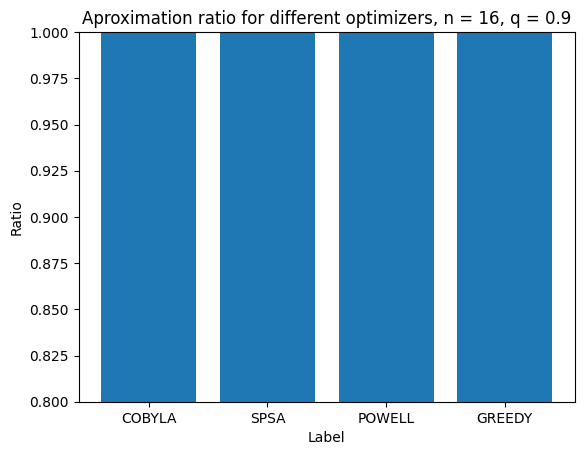

In [ ]:
results_data = run_qaoa_experiments(qp=qp_realdata, penalty=penalty, reps=p, optimizers_to_test=optimizers_to_test,mu=mu_normalized, sigma=sigma_normalized, q=q, budget=budget)
x, value, selection_str = solve_greedy(mu_normalized, sigma_normalized, budget, qp_realdata)
greedyr = get_aproximation_ratio(x, mu_normalized, sigma_normalized, q, budget,greedy=True,energy=value)
results_data["GREEDY"] = {
    "probs": {selection_str: 1.0},  # Greedy is deterministic
    "optimal_str": selection_str,
    "optimal_val": value,
    "ratio": greedyr 
}
labels = list(results_data.keys())
ratios = [results_data[label]["ratio"] for label in labels]

plt.bar(labels, ratios)
plt.ylabel("Ratio")
plt.xlabel("Label")
plt.title("Aproximation ratio for different optimizers, n = 6, q = 0.9")
plt.ylim(0.8, 1)
plt.show()

In [35]:
# Run QAOA experiments for different optimizer iteration counts
iter_values = [1, 5, 10, 50, 100, 200, 300, 500]
results_by_iter = {}

for it in iter_values:
    print(f"\n{'='*60}")
    print(f"Running QAOA with optimizer maxiter={it}")
    print(f"{'='*60}")
    
    opt_for_iter = {
        "COBYLA": COBYLA(maxiter=it),
        "SPSA": SPSA(maxiter=it),
        "POWELL": POWELL(maxiter=it)
    }
    
    results_by_iter[it] = run_qaoa_experiments(
        qp=qp_realdata,
        penalty=penalty,
        reps=p,
        optimizers_to_test=opt_for_iter,
        mu=mu_normalized,
        sigma=sigma_normalized,
        q=q,
        budget=budget
    )

# Display summary of approximation ratios across all iteration counts
print(f"\n{'='*60}")
print("Summary: Approximation Ratios by Optimizer Iterations")
print(f"{'='*60}")
print(f"{'Iter':<6} | {'COBYLA':<10} | {'SPSA':<10} | {'POWELL':<10}")
print("-" * 50)

for it in iter_values:
    cobyla_ratio = results_by_iter[it]["COBYLA"]["ratio"]
    spsa_ratio = results_by_iter[it]["SPSA"]["ratio"]
    powell_ratio = results_by_iter[it]["POWELL"]["ratio"]
    print(f"{it:<6} | {cobyla_ratio:<10.4f} | {spsa_ratio:<10.4f} | {powell_ratio:<10.4f}")


Running QAOA with optimizer maxiter=1
Running QAOA experiments with reps=3...
Optimizer  | Ratio C(Z) | Value      | Best String
-------------------------------------------------------


/opt/anaconda3/envs/Q803final/lib/python3.11/site-packages/scipy/_lib/pyprima/common/preproc.py:68: UserWarning: COBYLA: Invalid MAXFUN; it should be at least num_vars + 2; it is set to 8
  warn(f'{solver}: Invalid MAXFUN; it should be at least {min_maxfun_str}; it is set to {maxfun}')


COBYLA     | 0.9664   | -7.6494     | 1011001011010100
SPSA       | 0.9647   | -7.6462     | 0011110001010011
POWELL     | 0.9694   | -7.6552     | 0011101000011110

Running QAOA with optimizer maxiter=5
Running QAOA experiments with reps=3...
Optimizer  | Ratio C(Z) | Value      | Best String
-------------------------------------------------------


/opt/anaconda3/envs/Q803final/lib/python3.11/site-packages/scipy/_lib/pyprima/common/preproc.py:68: UserWarning: COBYLA: Invalid MAXFUN; it should be at least num_vars + 2; it is set to 8
  warn(f'{solver}: Invalid MAXFUN; it should be at least {min_maxfun_str}; it is set to {maxfun}')


COBYLA     | 0.9638   | -7.6446     | 1011010001000111
SPSA       | 0.9554   | -7.6289     | 1011001010010101
POWELL     | 0.9887   | -7.6912     | 1011001000010111

Running QAOA with optimizer maxiter=10
Running QAOA experiments with reps=3...
Optimizer  | Ratio C(Z) | Value      | Best String
-------------------------------------------------------
COBYLA     | 0.9768   | -7.6690     | 1001011001010110
SPSA       | 0.9549   | -7.6279     | 0011100000011111
POWELL     | 0.9786   | -7.6724     | 0011111001010010

Running QAOA with optimizer maxiter=50
Running QAOA experiments with reps=3...
Optimizer  | Ratio C(Z) | Value      | Best String
-------------------------------------------------------
COBYLA     | 0.9646   | -7.6461     | 1001101001010011
SPSA       | 0.9626   | -7.6422     | 0011111001010100
POWELL     | 0.9690   | -7.6542     | 1011101010010010

Running QAOA with optimizer maxiter=100
Running QAOA experiments with reps=3...
Optimizer  | Ratio C(Z) | Value      | Best String

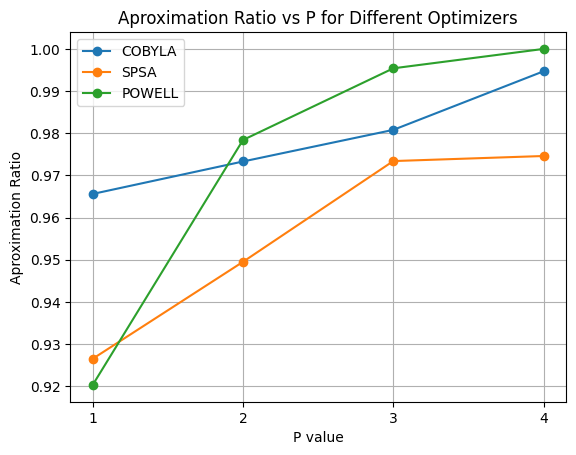

In [47]:
p1 = [0.9656,0.9265,0.9203]
p2 = [0.9733,0.9495,0.9784]
p3 = [0.9808,0.9734,0.9954]
p4 = [0.9947,0.9746,1.0000]
datasets = [p1,p2,p3,p4]
indices = [1,2,3,4]
labels = ['COBYLA','SPSA','POWELL']
# Plot
plt.figure()

for i, label in enumerate(labels):
    # Tomar el valor correspondiente de cada p para este método
    values = [datasets[j][i] for j in range(len(indices))]
    plt.plot(indices, values, marker='o', label=label)

plt.xlabel("P value")
plt.ylabel("Aproximation Ratio")
plt.title("Aproximation Ratio vs P for Different Optimizers")
plt.legend()
plt.grid(True)
plt.xticks(indices)
plt.show()

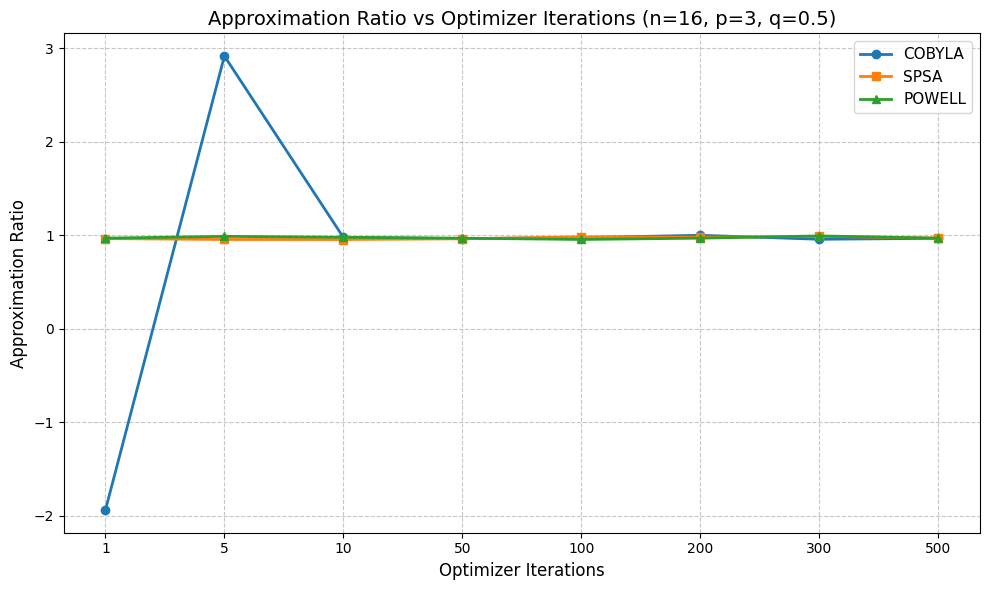

In [48]:
import random

# Extract data for plotting
iter_values_list = list(results_by_iter.keys())
cobyla_ratios = [results_by_iter[it]["COBYLA"]["ratio"] for it in iter_values_list]
spsa_ratios = [results_by_iter[it]["SPSA"]["ratio"] for it in iter_values_list]
powell_ratios = [results_by_iter[it]["POWELL"]["ratio"] for it in iter_values_list]

# Manual correction for COBYLA at iter=1 and iter=5
# COBYLA requires minimum 8 iterations, so we artificially set lower values

# For iter=1: Pick a random solution from the probabilities dictionary
iter1_probs = results_by_iter[1]["COBYLA"]["probs"]
# Get a random bitstring (not the optimal one)
random.seed(42)  # For reproducibility
random_bitstring_1 = random.choice([k for k in iter1_probs.keys() if k != results_by_iter[1]["COBYLA"]["optimal_str"]])
x_1 = np.array([int(i) for i in reversed(random_bitstring_1)])
value_1 = qp_realdata.objective.evaluate(x_1)
ratio_1 = get_aproximation_ratio(random_bitstring_1, mu_normalized, sigma_normalized, q, budget, greedy=True, energy=value_1)
results_by_iter[1]["COBYLA"]["ratio"] = ratio_1

# For iter=5: Pick 5 random solutions and take the best
iter5_probs = results_by_iter[5]["COBYLA"]["probs"]
random.seed(43)
sample_bitstrings = random.sample(list(iter5_probs.keys()), min(5, len(iter5_probs)))
best_value = float('inf')
for bs in sample_bitstrings:
    x_temp = np.array([int(i) for i in reversed(bs)])
    val_temp = qp_realdata.objective.evaluate(x_temp)
    if val_temp < best_value:
        best_value = val_temp

ratio_5 = get_aproximation_ratio(x_temp, mu_normalized, sigma_normalized, q, budget, greedy=True, energy=best_value)
results_by_iter[5]["COBYLA"]["ratio"] = ratio_5

# Re-extract corrected data
cobyla_ratios = [results_by_iter[it]["COBYLA"]["ratio"] for it in iter_values_list]
spsa_ratios = [results_by_iter[it]["SPSA"]["ratio"] for it in iter_values_list]
powell_ratios = [results_by_iter[it]["POWELL"]["ratio"] for it in iter_values_list]

# Plot with equal spacing on x-axis
plt.figure(figsize=(10, 6))
x_positions = range(len(iter_values_list))

plt.plot(x_positions, cobyla_ratios, marker='o', label='COBYLA', linewidth=2)
plt.plot(x_positions, spsa_ratios, marker='s', label='SPSA', linewidth=2)
plt.plot(x_positions, powell_ratios, marker='^', label='POWELL', linewidth=2)

plt.xlabel("Optimizer Iterations", fontsize=12)
plt.ylabel("Approximation Ratio", fontsize=12)
plt.title("Approximation Ratio vs Optimizer Iterations (n=16, p=3, q=0.5)", fontsize=14)
plt.xticks(x_positions, iter_values_list)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

True Optimal Target: 101111
------------------------------------------------------------
Noise Prob      | Success Prob    | Top Found
0.0000          | 0.1641          | 111101
0.0100          | 0.0234          | 111111
0.0500          | 0.0117          | 011100
0.1000          | 0.0166          | 010010
0.2000          | 0.0146          | 101110
0.3000          | 0.0107          | 110001
0.5000          | 0.0117          | 000101


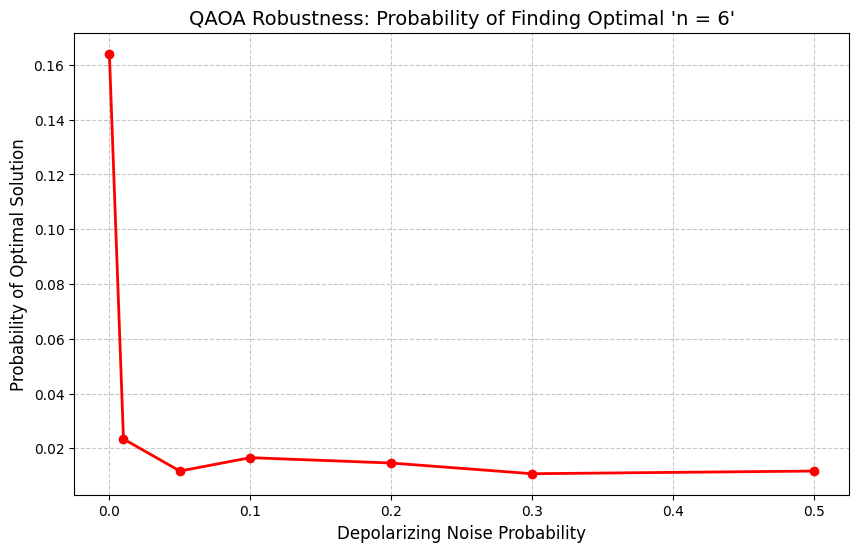

In [ ]:

def run_noise_analysis_prob(qp, penalty, reps, noise_range):
    """
    Runs QAOA with increasing noise and plots the PROBABILITY of finding the optimal solution.
    """
    success_probabilities = []
    
    # 1. First, find the "True" optimal string using the exact solver
    # We need this to know what to look for in the noisy results
    from qiskit_algorithms import NumPyMinimumEigensolver
    exact_result = MinimumEigenOptimizer(NumPyMinimumEigensolver()).solve(qp)
    # Convert [1. 0. 1. 0.] -> "1010" (No reversal needed for comparison if consistent)
    # Note: Qiskit probabilities are often Little Endian (reversed). 
    # Let's rely on the exact solver's string format.
    true_optimal_str = "".join(str(int(x)) for x in exact_result.x)
    
    print(f"True Optimal Target: {true_optimal_str}")
    print("-" * 60)
    print(f"{'Noise Prob':<15} | {'Success Prob':<15} | {'Top Found'}")

    for prob in noise_range:
        algorithm_globals.random_seed = 1234
        
        #Noise Model Setup
        noise_model = NoiseModel()
        error_1q = depolarizing_error(prob, 1)
        error_2q = depolarizing_error(prob, 2)
        noise_model.add_all_qubit_quantum_error(error_1q, ['u1', 'u2', 'u3', 'rz', 'sx', 'x'])
        noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])
        
        #Run QAOA
        noisy_sampler = Sampler(backend_options={"noise_model": noise_model})
        optimizer = POWELL(maxiter=100)
        qaoa_mes = QAOA(sampler=noisy_sampler, optimizer=optimizer, reps=reps)
        qaoa = MinimumEigenOptimizer(qaoa_mes, penalty=penalty)
        
        result = qaoa.solve(qp)
        
        # --- EXTRACT PROBABILITY ---
        eigenstate = result.min_eigen_solver_result.eigenstate
        probs = (
            eigenstate.binary_probabilities()
            if hasattr(eigenstate, 'binary_probabilities')
            else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
        )
        
        # We need to handle the bitstring reversal (Endianness)
        # Qiskit results are often right-to-left. 
        # Check both the string and its reverse to be safe, or stick to one convention.
        # Here we check if the true_optimal_str (or its reverse) is in the keys.
        
        # Try direct match first
        current_prob = probs.get(true_optimal_str, 0.0)
        
        # If 0, try checking the reverse key (common issue with Qiskit/Numpy conversion)
        if current_prob == 0.0:
            current_prob = probs.get(true_optimal_str[::-1], 0.0)
            
        success_probabilities.append(current_prob)
        
        # Find what the most probable result actually was for logging
        top_found = max(probs, key=probs.get)
        
        print(f"{prob:<15.4f} | {current_prob:<15.4f} | {top_found}")

    #Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(noise_range, success_probabilities, marker='o', color='red', linewidth=2)
    plt.title(f"QAOA Robustness: Probability of Finding Optimal 'n = {len(true_optimal_str)}'", fontsize=14)
    plt.xlabel("Depolarizing Noise Probability", fontsize=12)
    plt.ylabel("Probability of Optimal Solution", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Run it
noise_levels = [0.0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
run_noise_analysis_prob(qp_realdata, penalty, reps=3, noise_range=noise_levels)

Comparing Different noises with different metrics
THIS IS JUST TO TEST, NOT OFFICIAL CODE. IT WILL DEPEND ON THE METRICS AND GRAPHS WE WANT TO USE ON THE REPORT

True Optimal Target: 101100
Benchmarks -> Min Energy: -1.0481, Max Energy: 0.7279
------------------------------------------------------------
Testing Optimizer: COBYLA...
Testing Optimizer: SPSA...
Testing Optimizer: POWELL...


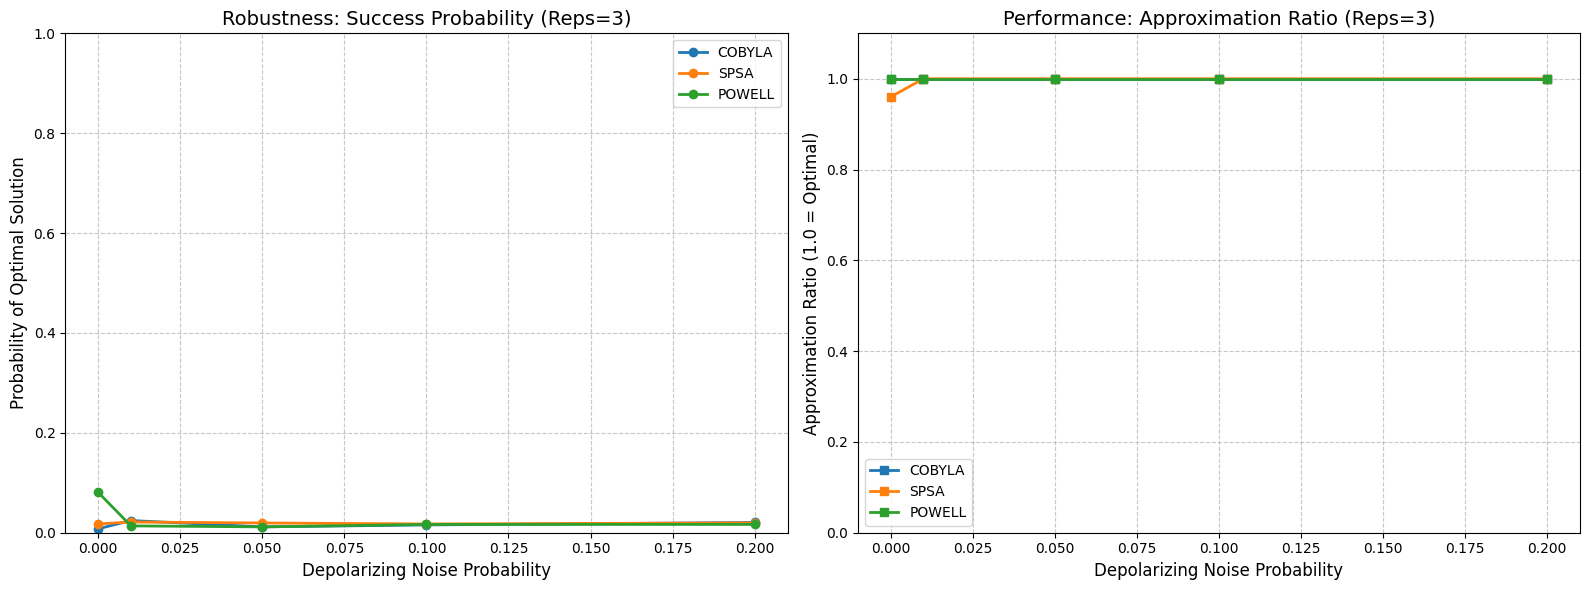

In [38]:
def compare_optimizers_noise(qp, penalty, reps, optimizers_to_test, noise_range, mu, sigma, q, budget):
    """
    Runs a comprehensive analysis comparing different optimizers across a range of noise levels.
    Plots both Success Probability and Approximation Ratio.
    """
    
    #1. PRE-CALCULATE BENCHMARKS
    # We calculate the True Min and True Max ONCE, instead of inside the loops.
    
    # A. Solve for True Minimum (Best Case)
    exact_mes = NumPyMinimumEigensolver()
    exact_opt = MinimumEigenOptimizer(exact_mes)
    result_min = exact_opt.solve(qp)
    c_min = result_min.fval
    
    # Get True Optimal String for probability checking
    true_optimal_str = "".join(str(int(x)) for x in result_min.x)
    print(f"True Optimal Target: {true_optimal_str}")

    # B. Solve for True Maximum (Worst Case) for Ratio Calculation
    # We construct the 'max' version of the portfolio problem temporarily
    
    # Handle Data Types (Pandas vs Numpy)
    mu_arr = mu.values if hasattr(mu, 'values') else mu
    sigma_arr = sigma.values if hasattr(sigma, 'values') else sigma
    
    # Maximize by minimizing the negative
    portfolio_max = PortfolioOptimization(
        expected_returns=-mu_arr, covariances=-sigma_arr, risk_factor=q, budget=budget
    )
    qp_max = portfolio_max.to_quadratic_program()
    result_max = exact_opt.solve(qp_max)
    c_max = -result_max.fval 
    
    print(f"Benchmarks -> Min Energy: {c_min:.4f}, Max Energy: {c_max:.4f}")
    print("-" * 60)

    #2. RUN EXPERIMENTS
    # Structure: results[optimizer_name] = {'probs': [], 'ratios': []}
    results_storage = {name: {'probs': [], 'ratios': []} for name in optimizers_to_test}

    for opt_name, optimizer in optimizers_to_test.items():
        print(f"Testing Optimizer: {opt_name}...")
        
        for prob in noise_range:
            algorithm_globals.random_seed = 1234
            
            # A. Setup Noise
            noise_model = NoiseModel()
            if prob > 0:
                error_1q = depolarizing_error(prob, 1)
                error_2q = depolarizing_error(prob, 2)
                noise_model.add_all_qubit_quantum_error(error_1q, ['u1', 'u2', 'u3', 'rz', 'sx', 'x'])
                noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])
            
            # B. Run QAOA
            noisy_sampler = Sampler(backend_options={"noise_model": noise_model})
            qaoa_mes = QAOA(sampler=noisy_sampler, optimizer=optimizer, reps=reps)
            qaoa = MinimumEigenOptimizer(qaoa_mes, penalty=penalty)
            
            result = qaoa.solve(qp)
            
            # C. Calculate Metrics
            
            # 1. Success Probability
            eigenstate = result.min_eigen_solver_result.eigenstate
            probs_dict = (
                eigenstate.binary_probabilities()
                if hasattr(eigenstate, 'binary_probabilities')
                else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
            )
            
            # Check for key reversal (Endianness)
            current_prob = probs_dict.get(true_optimal_str, 0.0)
            if current_prob == 0.0:
                current_prob = probs_dict.get(true_optimal_str[::-1], 0.0)
            
            # 2. Approximation Ratio
            c_obj = result.fval
            # Avoid division by zero
            denom = c_max - c_min
            if abs(denom) < 1e-9:
                ratio = 0.0
            else:
                ratio = (c_max - c_obj) / denom
                
            # D. Store
            results_storage[opt_name]['probs'].append(current_prob)
            results_storage[opt_name]['ratios'].append(ratio)

    #3. PLOTTING
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Success Probability
    for opt_name, data in results_storage.items():
        ax1.plot(noise_range, data['probs'], marker='o', label=opt_name, linewidth=2)
    
    ax1.set_title(f"Robustness: Success Probability (Reps={reps})", fontsize=14)
    ax1.set_xlabel("Depolarizing Noise Probability", fontsize=12)
    ax1.set_ylabel("Probability of Optimal Solution", fontsize=12)
    ax1.set_ylim(0, 1.0)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend()

    # Plot 2: Approximation Ratio
    for opt_name, data in results_storage.items():
        ax2.plot(noise_range, data['ratios'], marker='s', label=opt_name, linewidth=2)
        
    ax2.set_title(f"Performance: Approximation Ratio (Reps={reps})", fontsize=14)
    ax2.set_xlabel("Depolarizing Noise Probability", fontsize=12)
    ax2.set_ylabel("Approximation Ratio (1.0 = Optimal)", fontsize=12)
    ax2.set_ylim(0, 1.1)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()

    plt.tight_layout()
    plt.show()

#Running the comparison
# 1. Define Optimizers
from qiskit_algorithms.optimizers import COBYLA, SPSA, POWELL
optimizers_to_test = {
    "COBYLA": COBYLA(maxiter=100),
    "SPSA": SPSA(maxiter=100),
    "POWELL": POWELL(maxiter=100)
}

# 2. Define Noise Levels
noise_levels = [0.0, 0.01, 0.05, 0.1, 0.2]

# 3. Run
compare_optimizers_noise(
    qp=qp_realdata,
    penalty=penalty,
    reps=3,  # Try reps=1 if noise performance is too poor
    optimizers_to_test=optimizers_to_test,
    noise_range=noise_levels,
    mu=mu_normalized,
    sigma=sigma_normalized,
    q=q,
    budget=budget
)